In [1]:
import fitsio
import matplotlib.pyplot as plt
import numpy as np
import time
import coord
%matplotlib inline

In [2]:
# https://opensource.ncsa.illinois.edu/confluence/display/DESDM/SVA1+GOLD+Catalog
data = fitsio.read('sva1_gold_r1.0_catalog.fits')
print(data.dtype.names)

('COADD_OBJECTS_ID', 'RA', 'DEC', 'MODEST_CLASS', 'FLAGS_G', 'FLAGS_R', 'FLAGS_I', 'FLAGS_Z', 'BADFLAG', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'MAGERR_AUTO_G', 'MAGERR_AUTO_R', 'MAGERR_AUTO_I', 'MAGERR_AUTO_Z', 'MAG_PSF_G', 'MAG_PSF_R', 'MAG_PSF_I', 'MAG_PSF_Z', 'MAGERR_PSF_G', 'MAGERR_PSF_R', 'MAGERR_PSF_I', 'MAGERR_PSF_Z', 'SPREAD_MODEL_G', 'SPREAD_MODEL_R', 'SPREAD_MODEL_I', 'SPREAD_MODEL_Z', 'SPREADERR_MODEL_G', 'SPREADERR_MODEL_R', 'SPREADERR_MODEL_I', 'SPREADERR_MODEL_Z', 'CLASS_STAR_G', 'CLASS_STAR_R', 'CLASS_STAR_I', 'CLASS_STAR_Z', 'FLUX_RADIUS_G', 'FLUX_RADIUS_R', 'FLUX_RADIUS_I', 'FLUX_RADIUS_Z')


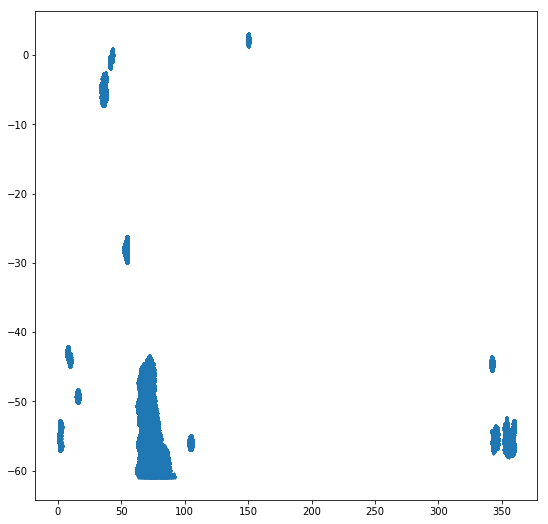

In [3]:
plt.rcParams['figure.figsize'] = (9,9)  # Change all subsequent figure sizes too.
plt.scatter(data['RA'], data['DEC'], s=0.01)
plt.show()

In [4]:
# Pick out just the main SV region to work with
mask = (data['RA'] > 50) & (data['RA'] < 100) & (data['DEC'] < -40) & (data['DEC'] > -65)
data = data[mask]
print(data.shape)

(16640983,)


In [104]:
# It's still pretty big, especially for some of the slower codes I want to compare to.
# Select a random million objects from this.
N = 1000000
indx = np.random.choice(len(data), size=N, replace=False)
ra = data['RA'][indx]
dec = data['DEC'][indx]
print(ra.shape, dec.shape)

(1000000,) (1000000,)


In [105]:
# Write out the smaller catalog, so we can skip the above steps in the future.
import treecorr
cat = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg')
cat.write('des_sv.fits')

In [106]:
# Now we can start here instead to save some time if we want.
import fitsio
import matplotlib.pyplot as plt
import numpy as np
import time
import coord
%matplotlib inline
import treecorr
import importlib
importlib.reload(treecorr)
plt.rcParams['figure.figsize'] = (9,9)
cat = treecorr.Catalog('des_sv.fits', ra_col='ra', dec_col='dec', ra_units='deg', dec_units='deg')
ra = cat.ra * (coord.radians / coord.degrees)
dec = cat.dec * (coord.radians / coord.degrees)

In [107]:
ra_rad = ra * (coord.degrees / coord.radians)
dec_rad = dec * (coord.degrees / coord.radians)
x, y, z = coord.CelestialCoord.radec_to_xyz(ra_rad, dec_rad)

In [108]:
import matplotlib.cm as cm
npatch = 40
colors = cm.rainbow(np.linspace(0, 1, npatch))
np.random.shuffle(colors)

In [109]:
import scipy
from scipy.cluster.vq import kmeans2
t0 = time.time()
xyz = np.array([x, y, z]).T
# The default minit is 'random', which doesn't work on data that isn't rectangular
cen, scipy_labels = kmeans2(xyz, npatch, minit='points')
t1 = time.time()
scipy_time = t1-t0
print('Time = ',t1-t0)

Time =  3.2371928691864014


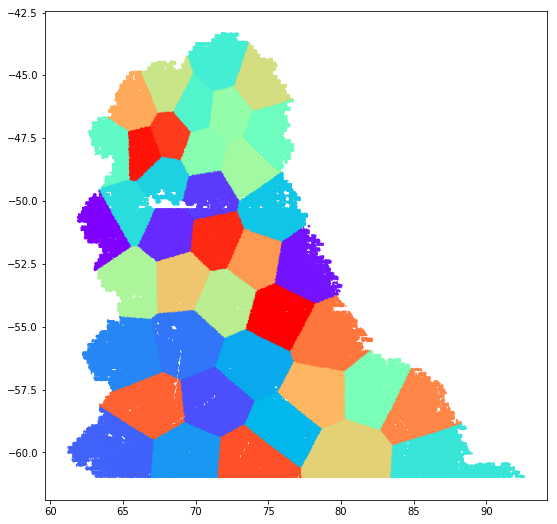

In [110]:
plt.scatter(ra, dec, color=colors[scipy_labels],s=0.1)
plt.show()

In [111]:
import scipy
from scipy.cluster.vq import kmeans2
t0 = time.time()
xyz = np.array([x, y, z]).T
# The scipy defaults don't do a great job.  Dialing up the number of iterations helps.
# Unfortunately, they haven't implemented their thresh parameter yet, so this is kind of a guess.
cen, scipy2_labels = kmeans2(xyz, npatch, minit='points', iter=50)
t1 = time.time()
scipy2_time = t1-t0
print('Time = ',t1-t0)

Time =  14.162523984909058


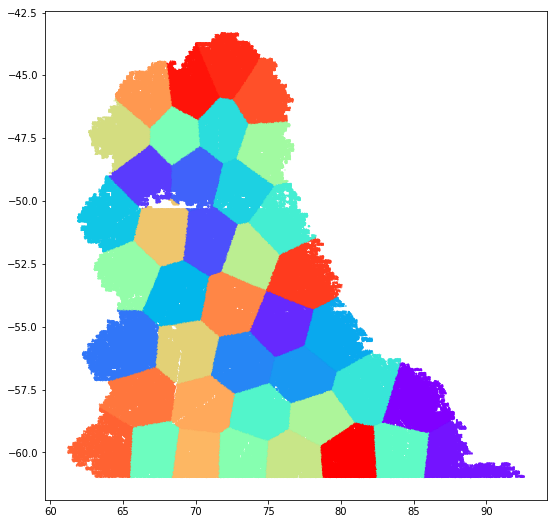

In [112]:
plt.scatter(ra, dec, color=colors[scipy2_labels],s=0.1)
plt.show()

In [113]:
import kmeans_radec
t0 = time.time()
radec = np.array([ra, dec]).T
km = kmeans_radec.kmeans_sample(radec, npatch, maxiter=100, tol=1.0e-5)
es_labels = km.labels
t1 = time.time()
es_time = t1-t0
print('Time = ',t1-t0)

X (2000, 2)  centers (40, 2)  tol=1e-05  maxiter=100
41 iterations  cluster sizes: [57 55 66 30 37 63 63 41 56 36 33 40 50 48 61 14 35 14 39 46 63 86 55 76
 30 76 62 43 36 66 59 36 50 50 46 73 48 50 73 38]
X (1000000, 2)  centers (40, 2)  tol=1e-05  maxiter=100
46 iterations  cluster sizes: [25531 27160 22002 23431 18937 24971 26586 24048 25318 19559 26313 27636
 20986 22432 26638 23301 26096 17493 30122 25209 26637 27692 32765 28606
 21693 31094 20726 22064 26229 23919 29279 26940 22047 23743 23251 28700
 24447 26395 27081 22923]
Time =  192.6874029636383


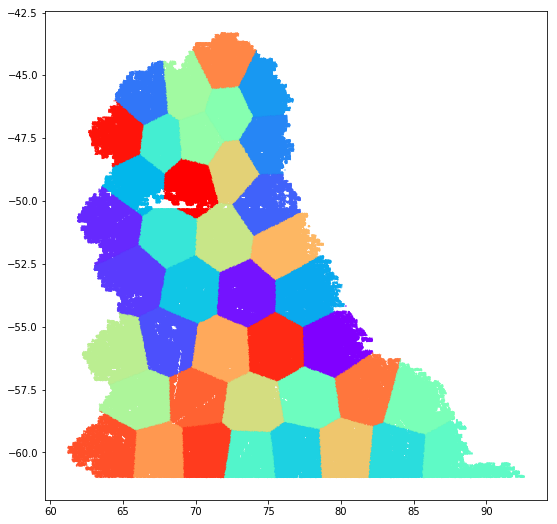

In [114]:
plt.scatter(ra, dec, color=colors[es_labels], s=0.1)
plt.show()

In [115]:
import pyclustering.cluster.kmeans
import pyclustering.cluster.center_initializer
# create instance of K-Means algorithm
t0 = time.time()
xyz = np.array([x, y, z]).T
pyc_centers = pyclustering.cluster.center_initializer.kmeans_plusplus_initializer(xyz, npatch).initialize();
# ccore=True is supposedly faster, but doesn't work on MacOS
kmeans_instance = pyclustering.cluster.kmeans.kmeans(xyz, pyc_centers, ccore=False)
# run cluster analysis and obtain results
kmeans_instance.process()
pyc_clusters = kmeans_instance.get_clusters()
pyc_labels = np.zeros_like(ra, dtype=int)
for i, cl in enumerate(pyc_clusters):
    pyc_labels[cl] = i
t1 = time.time()
pyc_time = t1-t0
print('Time = ',t1-t0)

Time =  79.10792088508606


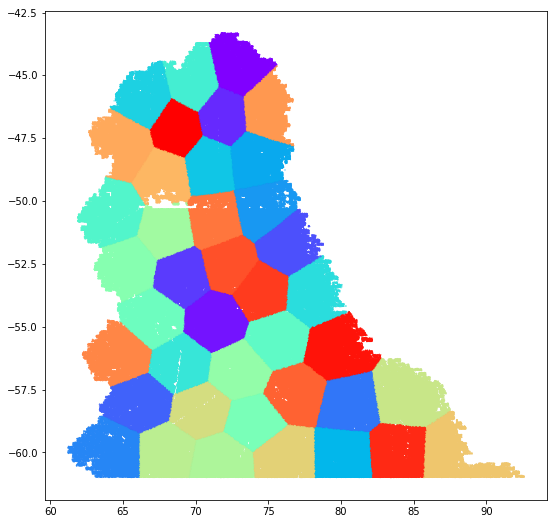

In [116]:
plt.scatter(ra, dec, color=colors[pyc_labels], s=0.1)
plt.show()

In [117]:
import sklearn.cluster
t0 = time.time()
# By default, this wants to run 10 times and take the best, which makes it ridiculously slower than
# everything else here.  So just run one initialization instead.
sk_kmeans = sklearn.cluster.KMeans(n_clusters=npatch, n_init=1)
xyz = np.array([x, y, z]).T
sk_kmeans.fit(xyz)
sk_labels = sk_kmeans.labels_
t1 = time.time()
sk_time = t1-t0
print('Time = ',t1-t0)

Time =  172.79221391677856


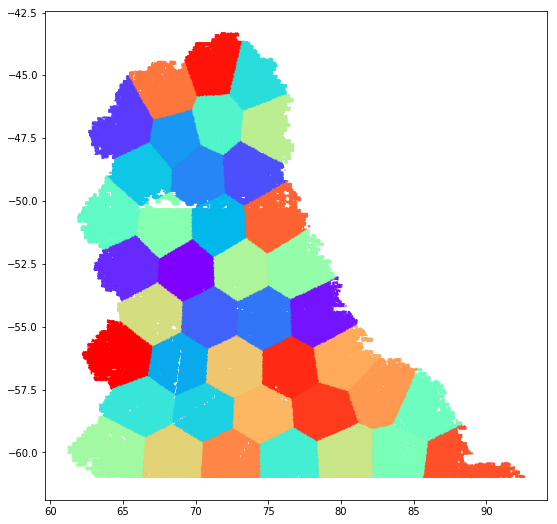

In [118]:
plt.scatter(ra, dec, color=colors[sk_labels], s=0.1)
plt.show()

In [119]:
import sklearn.cluster
t0 = time.time()
mb_kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=npatch)
xyz = np.array([x, y, z]).T
mb_kmeans.fit(xyz)
mb_labels = mb_kmeans.labels_
t1 = time.time()
mb_time = t1-t0
print('Time = ',t1-t0)

Time =  15.016757011413574


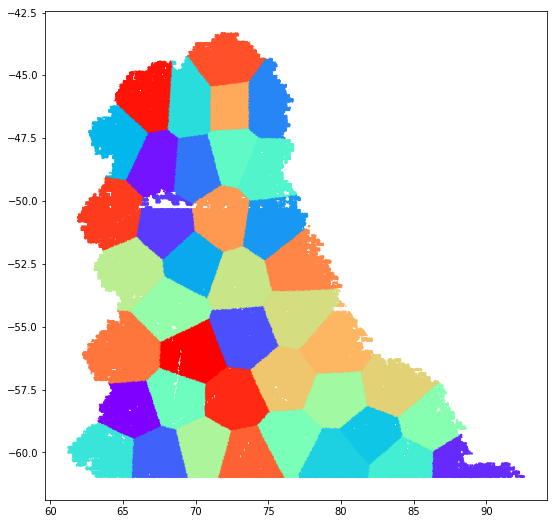

In [120]:
plt.scatter(ra, dec, color=colors[mb_labels], s=0.1)
plt.show()

In [121]:
t0 = time.time()
# repeat the Catalog creation to be fair for the timing comparison.
cat = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg')
field = cat.getNField()
tc_labels = field.run_kmeans(npatch, tol=1.e-5, max_iter=200)
t1 = time.time()
tc_time = t1-t0
print('Time = ',t1-t0)

Time =  3.3181519508361816


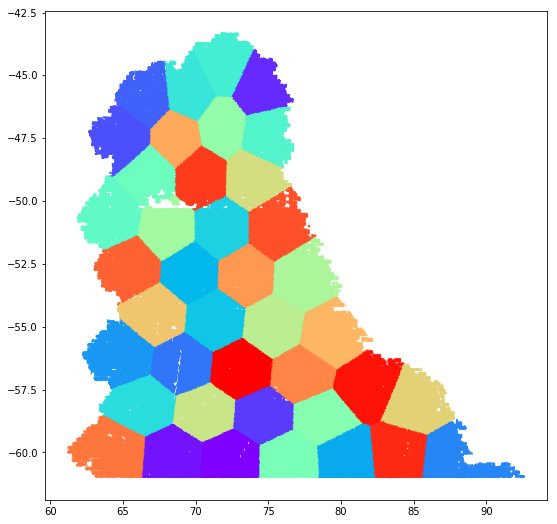

In [122]:
plt.scatter(ra, dec, color=colors[tc_labels], s=0.1)
plt.show()

In [123]:
# TreeCorr with the alternate algorithm
t0 = time.time()
# repeat the Catalog creation to be fair for the timing comparison.
cat = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg')
field = cat.getNField()
tc2_labels = field.run_kmeans(npatch, alt=True, tol=1.e-5, max_iter=200)
t1 = time.time()
tc2_time = t1-t0
print('Time = ',t1-t0)

Time =  2.2699191570281982


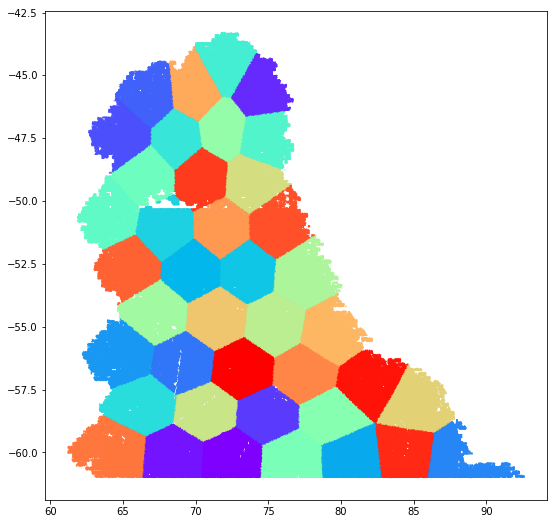

In [124]:
plt.scatter(ra, dec, color=colors[tc2_labels], s=0.1)
plt.show()

In [125]:
print('KMeans Code        Time    Inertia   RMS Intertia   Mean Size   RMS Size    RMS Counts   Counts Range')
print()
for name, labels, t in [('SciPy 10 iter', scipy_labels, scipy_time),
                        ('SciPy 50 iter', scipy2_labels, scipy2_time),
                        ('KMeans_RADec', es_labels, es_time), 
                        ('PyClustering', pyc_labels, pyc_time),
                        ('SciKit KMeans', sk_labels, sk_time),
                        ('SK MiniBatch', mb_labels, mb_time),
                        ('TreeCorr def', tc_labels, tc_time),
                        ('TreeCorr alt', tc2_labels, tc2_time)]:
    cen = np.array([xyz[labels==i].mean(axis=0) for i in range(npatch)])
    inertia = np.array([np.sum((xyz[labels==i] - cen[i])**2) for i in range(npatch)])
    sizes = np.array([np.mean((xyz[labels==i] - cen[i])**2) for i in range(npatch)])**0.5
    sizes *= 180./np.pi * 60  # Convert to arcmin
    counts = np.array([np.sum(labels==i) for i in range(npatch)])
    print('%s\t %6.2f     %5.2f      %.3f         %.3f      %.3f        %.0f     %5d .. %d'%(
        name, t, np.sum(inertia), np.std(inertia),
        np.mean(sizes), np.std(sizes), np.std(counts),                                                    
        np.min(counts), np.max(counts)))
    with open('kmeans_stats.dat', 'a+') as f:
        f.write('%s  \t %8.4f \t %9.5f \t %9.5f \t %8.5e \t %8.5e \t %9.3f\n'%(
            name, t, np.sum(inertia), np.std(inertia), np.mean(sizes), np.std(sizes), np.std(counts)))


KMeans Code        Time    Inertia   RMS Intertia   Mean Size   RMS Size    RMS Counts   Counts Range

SciPy 10 iter	   3.24     229.51      2.752         29.166      3.423        7097     12791 .. 46674
SciPy 50 iter	  14.16     212.15      0.915         28.839      2.108        2466     16474 .. 29471
KMeans_RADec	 192.69     212.11      1.044         28.811      1.992        3271     17493 .. 32765
PyClustering	  79.11     211.67      1.001         28.821      1.839        3377     18227 .. 33048
SciKit KMeans	 172.79     209.36      0.759         28.723      1.612        2927     19532 .. 30924
SK MiniBatch	  15.02     219.15      1.379         29.141      2.434        3771     14436 .. 32620
TreeCorr def	   3.32     208.56      0.597         28.686      1.624        2391     20413 .. 29103
TreeCorr alt	   2.27     209.03      0.231         28.779      1.350        2372     19845 .. 29762


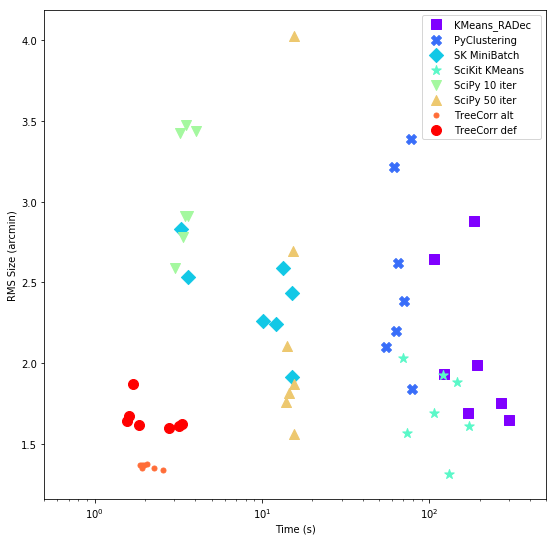

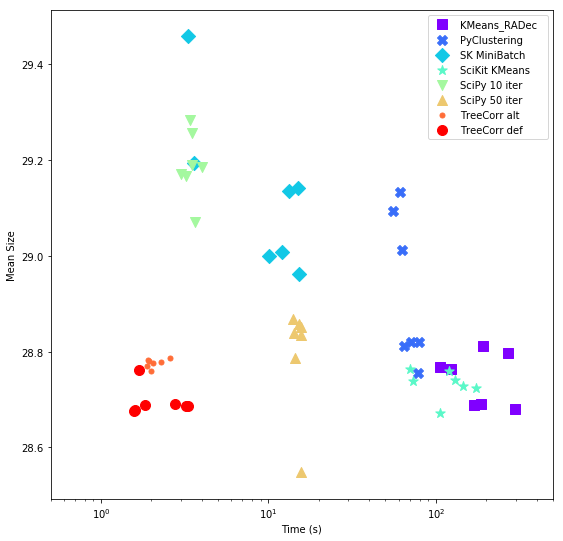

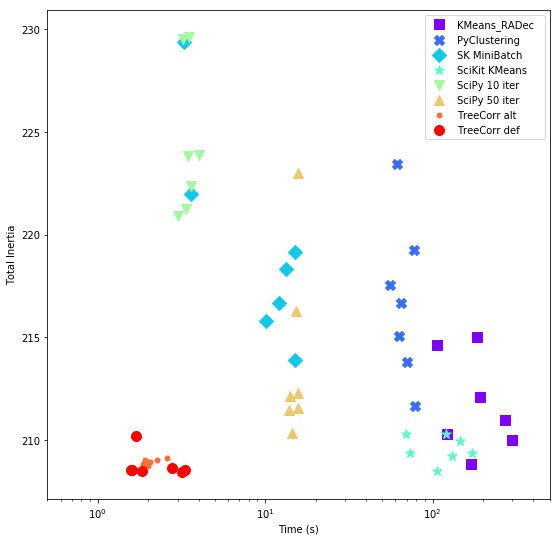

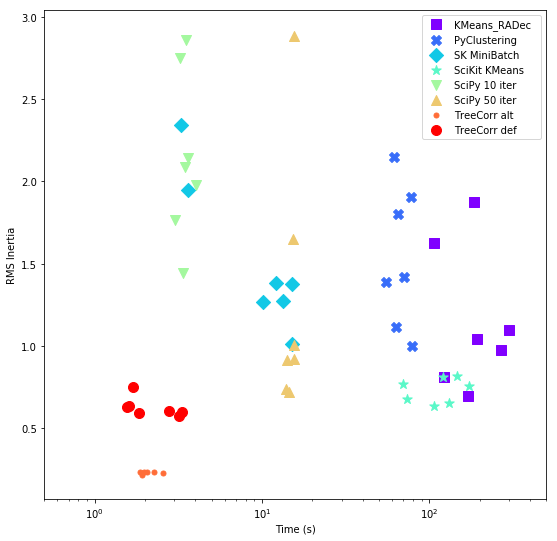

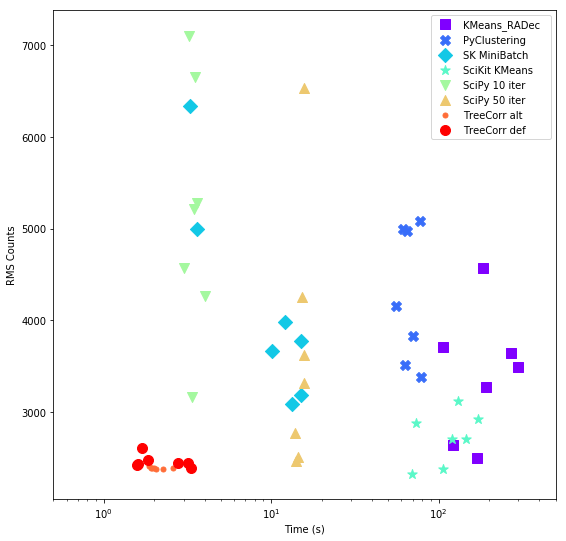

In [126]:
import matplotlib.patches as mp
stats = np.loadtxt('kmeans_stats.dat', 
                   dtype={'names': ('code', 'time', 'inertia', 'rms_inertia', 'mean_size', 'rms_size', 'rms_counts'),
                          'formats': ('U14', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4')},
                   delimiter='\t')
#print(stats)
#print(stats.dtype)
codes = np.unique(stats['code'])
#print(codes)
stats_colors = cm.rainbow(np.linspace(0, 1, len(codes)))
#print(stats_colors)
markers = ['s', 'X', 'D', '*', 'v', '^', '.', 'o']
dots = []
for i, c in enumerate(codes):
    mask = stats['code'] == c
    dot = plt.scatter(stats['time'][mask], stats['rms_size'][mask], s=100, c=[stats_colors[i]], marker=markers[i])
    dots.append(dot)
plt.xscale('log')
plt.xlim(0.5, 500)
plt.xlabel('Time (s)')
plt.ylabel('RMS Size (arcmin)')
plt.legend(dots, codes, loc='upper right')
plt.show()

for i, c in enumerate(codes):
    mask = stats['code'] == c
    dot = plt.scatter(stats['time'][mask], stats['mean_size'][mask], s=100, c=[stats_colors[i]], marker=markers[i])
    dots.append(dot)
plt.xscale('log')
plt.xlim(0.5, 500)
plt.xlabel('Time (s)')
plt.ylabel('Mean Size')
plt.legend(dots, codes, loc='upper right')
plt.show()

for i, c in enumerate(codes):
    mask = stats['code'] == c
    dot = plt.scatter(stats['time'][mask], stats['inertia'][mask], s=100, c=[stats_colors[i]], marker=markers[i])
    dots.append(dot)
plt.xscale('log')
plt.xlim(0.5, 500)
plt.xlabel('Time (s)')
plt.ylabel('Total Inertia')
plt.legend(dots, codes, loc='upper right')
plt.show()

for i, c in enumerate(codes):
    mask = stats['code'] == c
    dot = plt.scatter(stats['time'][mask], stats['rms_inertia'][mask], s=100, c=[stats_colors[i]], marker=markers[i])
    dots.append(dot)
plt.xscale('log')
plt.xlim(0.5, 500)
plt.xlabel('Time (s)')
plt.ylabel('RMS Inertia')
plt.legend(dots, codes, loc='upper right')
plt.show()

for i, c in enumerate(codes):
    mask = stats['code'] == c
    dot = plt.scatter(stats['time'][mask], stats['rms_counts'][mask], s=100, c=[stats_colors[i]], marker=markers[i])
    dots.append(dot)
plt.xscale('log')
plt.xlim(0.5, 500)
plt.xlabel('Time (s)')
plt.ylabel('RMS Counts')
plt.legend(dots, codes, loc='upper right')
plt.show()